# House Prices basic Feature Engineering baselining

This notebook will illustrate how to build a basic pipeline for a regression problem. The same structure could be applied to a classification problem, of course. In this case, we will start from the cleaned dataset of the Kaggle competition on predicting House prices (https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data). The cleaning has been done from Dataiku.

![Dataiku Data Preparation Pipeline](./data/dataiku_dataprep.png)

You can find this notebook in [github.com/renero/class_notebooks](https://github.com/renero/class_notebooks/)

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#House-Prices-basic-Feature-Engineering-baselining" data-toc-modified-id="House-Prices-basic-Feature-Engineering-baselining-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>House Prices basic Feature Engineering baselining</a></span><ul class="toc-item"><li><span><a href="#Pipeline-design" data-toc-modified-id="Pipeline-design-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Pipeline design</a></span></li><li><span><a href="#Read-and-Prepare-data" data-toc-modified-id="Read-and-Prepare-data-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Read and Prepare data</a></span><ul class="toc-item"><li><span><a href="#Impute-with-the-default-value,-not-NA" data-toc-modified-id="Impute-with-the-default-value,-not-NA-1.2.1"><span class="toc-item-num">1.2.1&nbsp;&nbsp;</span>Impute with the default value, not NA</a></span></li><li><span><a href="#Fix-type-of-feature" data-toc-modified-id="Fix-type-of-feature-1.2.2"><span class="toc-item-num">1.2.2&nbsp;&nbsp;</span>Fix type of feature</a></span></li><li><span><a href="#Encoding-categorical-variables" data-toc-modified-id="Encoding-categorical-variables-1.2.3"><span class="toc-item-num">1.2.3&nbsp;&nbsp;</span>Encoding categorical variables</a></span></li><li><span><a href="#Fix-Skewness-(we're-using-linear-regression)" data-toc-modified-id="Fix-Skewness-(we're-using-linear-regression)-1.2.4"><span class="toc-item-num">1.2.4&nbsp;&nbsp;</span>Fix Skewness (we're using linear regression)</a></span></li></ul></li><li><span><a href="#Read-&amp;-Prepare-Data-Pipeline" data-toc-modified-id="Read-&amp;-Prepare-Data-Pipeline-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Read &amp; Prepare Data Pipeline</a></span></li><li><span><a href="#Linear-Regression-Model" data-toc-modified-id="Linear-Regression-Model-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Linear Regression Model</a></span><ul class="toc-item"><li><span><a href="#Feature-Creation-(manual)" data-toc-modified-id="Feature-Creation-(manual)-1.4.1"><span class="toc-item-num">1.4.1&nbsp;&nbsp;</span>Feature Creation (manual)</a></span></li><li><span><a href="#Outliers" data-toc-modified-id="Outliers-1.4.2"><span class="toc-item-num">1.4.2&nbsp;&nbsp;</span>Outliers</a></span></li><li><span><a href="#Under-representation" data-toc-modified-id="Under-representation-1.4.3"><span class="toc-item-num">1.4.3&nbsp;&nbsp;</span>Under-representation</a></span></li><li><span><a href="#Cross-Validation-evaluation" data-toc-modified-id="Cross-Validation-evaluation-1.4.4"><span class="toc-item-num">1.4.4&nbsp;&nbsp;</span>Cross Validation evaluation</a></span></li></ul></li><li><span><a href="#Run-it!" data-toc-modified-id="Run-it!-1.5"><span class="toc-item-num">1.5&nbsp;&nbsp;</span>Run it!</a></span><ul class="toc-item"><li><span><a href="#Make-predictions-and-play-with-results" data-toc-modified-id="Make-predictions-and-play-with-results-1.5.1"><span class="toc-item-num">1.5.1&nbsp;&nbsp;</span>Make predictions and play with results</a></span></li></ul></li><li><span><a href="#Pitfalls" data-toc-modified-id="Pitfalls-1.6"><span class="toc-item-num">1.6&nbsp;&nbsp;</span>Pitfalls</a></span></li></ul></li></ul></div>

## Pipeline design

Our basic pipeline will look like the function below. It is used with two arguments: the dataset and set of functions to try over the data. Internally, the function will loop over the specified function names to check if they improve the score (R2) of the model validated over the RAW test set. If so, the function is kept, and the data is updated according to that function. Otherwise, the function is simply rejected and the data suffer no change.

In [33]:
# Imports
import numpy as np
import pandas as pd
import statsmodels.api as sm
import warnings

from collections import defaultdict

from sklearn import preprocessing
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, KFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelBinarizer, RobustScaler

from scipy.stats import skew, boxcox_normmax
from scipy.special import boxcox1p

import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter(action='ignore')

In [6]:
def feature_engineering_pipeline(raw_data, fe_functions):
    selected_functions = []
    base_score = score_model(raw_data)
    print('Base Score: {:.4f}'.format(base_score))
    engineered_data = raw_data.copy()
    for fe_function in fe_functions:
        processed_data = globals()[fe_function](engineered_data)
        new_score = score_model(processed_data)
        print('- New Score ({}): {:.4f} '.format(fe_function, new_score), 
              end='')
        difference = (new_score-base_score)
        print('[diff: {:.4f}] '.format(difference), end='')
        if difference > -0.01:
            selected_functions.append(fe_function)
            engineered_data = processed_data.copy()
            base_score = new_score
            print('[Accepted]')
        else:
            print('[Rejected]')
    return selected_functions, engineered_data

We need to work on functions to:
  - read the data (`read_data`)
  - run the model over a dataset (`score_model`)
  - apply the different ideas that we come up with during the process
  
Notice that we haven't applied the split between training and test. That step will be done within the score_model function.

## Read and Prepare data

In [7]:
def read_data(input_path):
    raw_data = pd.read_csv(input_path, keep_default_na=False, na_values=['_'])
    return raw_data

### Impute with the default value, not NA
We documentation says that some of the features should take default values, and some others should be grouped as they're not very representative.

In [8]:
def replace(df, column, old_value, new_value):
    df.loc[df[column] == old_value, column] = new_value
    
def impute(df):
    replace(df, 'Electrical', 'NA', 'SBrkr')
    # Minority categories grouped into 'Other'
    [replace(df, 'Exterior1st', minor, 'Other') for minor in 
     ['Stone', 'AsphShn', 'CBlock', 'ImStucc']]
    [replace(df, 'Exterior2nd', minor, 'Other') for minor in 
     ['Stone', 'AsphShn', 'CBlock', 'ImStucc']]
    [replace(df, 'SaleType', minor, 'Oth') for minor in 
     ['ConLD', 'ConLI', 'ConLw', 'Con']]
    return df

### Fix type of feature
Change the type of some of the columns that look like numbers but they're really categories, to that: categories.

In [9]:
def fix_types(df):
    df['MSSubClass'] = df['MSSubClass'].astype('category')
    return df

### Encoding categorical variables

Need to encode categorical variables using one-hot encoding. I will detect which columns are not numerical, and will run one-hot encoding on them.

In [10]:
def numerical_features(df):
    columns = df.columns
    return df._get_numeric_data().columns

def categorical_features(df):
    numerical_columns = numerical_features(df)
    return(list(set(df.columns) - set(numerical_columns)))

def onehot_encode(df):
    numericals = df.get(numerical_features(df))
    new_df = numericals.copy()
    for categorical_column in categorical_features(df):
        new_df = pd.concat([new_df, 
                            pd.get_dummies(df[categorical_column], 
                                           prefix=categorical_column)], 
                           axis=1)
    return new_df

### Fix Skewness (we're using linear regression)

Try to identify what features present high skewness to fix it with the BoxCox method

In [11]:
def feature_skewness(df):
    numeric_dtypes = ['int16', 'int32', 'int64', 
                      'float16', 'float32', 'float64']
    numeric_features = []
    for i in df.columns:
        if df[i].dtype in numeric_dtypes: 
            numeric_features.append(i)

    feature_skew = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':feature_skew})
    return feature_skew, numeric_features

Now, that we know how to detect them, write a function to do all the job.

In [12]:
def fix_skewness(df):
    feature_skew, numeric_features = feature_skewness(df)
    high_skew = feature_skew[feature_skew > 0.5]
    skew_index = high_skew.index
    
    for i in skew_index:
        df[i] = boxcox1p(df[i], boxcox_normmax(df[i]+1))

    skew_features = df[numeric_features].apply(
        lambda x: skew(x)).sort_values(ascending=False)
    skews = pd.DataFrame({'skew':skew_features})
    return df

## Read & Prepare Data Pipeline
Transform RAW by imputing missing or rare values, fixing skewness and fixing some types that should not be numerical.

In [13]:
raw = read_data('./data/houseprices_prepared.csv.gz').drop(['Id'], axis=1)
prepared = fix_skewness(impute(fix_types(raw)))
print('Original shape before onehot encoding: {}'.format(prepared.shape))
dataset = pd.get_dummies(prepared)
print('Dataset shape AFTER onehot encoding: {}'.format(dataset.shape))

Original shape before onehot encoding: (1460, 79)
Dataset shape AFTER onehot encoding: (1460, 306)


## Linear Regression Model

This function will be called to run a linear regression model over the dataset passed as argument. It splits it into train and test, trains and evaluate the test set to finally return the R2 metric as a result

In [67]:
def score_model(data, seed=666):
    X = data.loc[:, data.columns != 'SalePrice']
    y = data.loc[:, 'SalePrice']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.20, 
                                                        random_state=seed)
    
    # Create linear regression object
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    return r2_score(y_test, y_pred)

### Feature Creation (manual)

Simply sum the square feet of the different parts of the house into a single column called HouseSF

In [15]:
def sum_SF(df):
    columns_to_add = ['1stFlrSF','2ndFlrSF','BsmtFinSF1','BsmtFinSF2']
    df['House_SF'] = df[columns_to_add].fillna('').sum(axis=1)
    df.drop(columns_to_add, axis=1)
    return df

def sum_Baths(df):
    df['Total_Baths'] = (df['FullBath'] + 
                         df['BsmtFullBath'] + 
                         (0.5*df['HalfBath']) + 
                         (0.5*df['BsmtHalfBath']))
    df.drop(['FullBath', 'HalfBath', 'BsmtFullBath', 'BsmtHalfBath'], axis=1)
    return df

def sum_Porch(df):
    columns_to_add = ['OpenPorchSF','3SsnPorch','EnclosedPorch',
                      'ScreenPorch','WoodDeckSF']
    df['Porch_sf'] = df[columns_to_add].sum(axis=1)
    df.drop(columns_to_add, axis=1)
    return df

### Outliers
We use the statsmodels package to solve this issue. Let's do a little bit more in-depth and rigorous analysis first on outliers. I'll employ Leave-One-Out methodology with OLS to find which points have a significant effect on our model fit.

In [16]:
def remove_outliers(df):
    X = df.drop(['SalePrice'], axis=1)
    y = df.SalePrice.reset_index(drop=True)
    ols = sm.OLS(endog = y, exog = X)
    fit = ols.fit()
    test = fit.outlier_test()['bonf(p)']
    outliers = list(test[test<1e-3].index) 
    df.drop(df.index[outliers])
    return df

### Under-representation

Eliminate those columns with most of the information belonging to the same class

In [17]:
def under_represented_features(df):
    under_rep = []
    for i in df.columns:
        counts = df[i].value_counts()
        zeros = counts.iloc[0]
        if ((zeros / len(df)) * 100) > 99.0:
            under_rep.append(i)
    df.drop(under_rep, axis=1, inplace=True)
    return df

### Cross Validation evaluation

Cross validation implies that instead of evaluating the model with a single split of train/test, we will use a k-fold technique, and that will produce different results. A realistic outcome would be the mean of all that process, but if you can check how far your model can reach by simply changing the training/test datasets using CV, I decided to take the 'max()' in the last line of the function. Try with the mean() to check some other results.

In [44]:
def cv_evaluate(df, splits=100):
    lm = LinearRegression()
    kfolds = KFold(n_splits=10, shuffle=True, random_state=23)

    X = df.drop(['SalePrice'], axis=1)
    y = df.SalePrice.reset_index(drop=True)
    benchmark_model = make_pipeline(RobustScaler(), lm).fit(X=X, y=y)
    scores = cross_val_score(benchmark_model, X, y, scoring='r2', cv=kfolds)
    return scores[scores >= 0.0]

## Run it!

It's time to run all our FE subprocesses together. As we designed everything, eveything starts with a baseline score, followed by a loop over the different Feature Engineering subtasks. At each of those steps it is assessed whether our score improves or get worse. In the later case, that modification is rejected, and accepted otherwise. At the end of the process, we can see the average value.

In [47]:
# I'm not adding the 'remove_outliers' to save time, since that step takes 
# some minutes to complete.
# You should add it to check the results for yourself
fe_functions = ['sum_SF','sum_Baths','sum_Porch',
                'under_represented_features'#,'remove_outliers'
               ]
funcs, new_dataset = feature_engineering_pipeline(dataset, fe_functions)

# After running the FE pipeline, I check how CV make my results shuffle, 
# as it takes different portions of the data each time, and that causes 
# different metric values
r2 = cv_evaluate(new_dataset, splits=100)
print('Mean R2 after CV: {:.3f} +/- {:.03f}'.format(np.mean(r2), np.std(r2)))

Base Score: 0.8766
- New Score (sum_SF): -33943647547.1517 [diff: -33943647548.0283] [Rejected]
- New Score (sum_Baths): 0.8766 [diff: -0.0000] [Accepted]
- New Score (sum_Porch): -1565009819.2675 [diff: -1565009820.1441] [Rejected]
- New Score (under_represented_features): 0.8771 [diff: 0.0006] [Accepted]
- New Score (remove_outliers): 0.8771 [diff: 0.0000] [Accepted]
Mean R2 after CV: 0.862 +/- 0.081


### Make predictions and play with results

Let's plot our predictions against the actual values to illustrate the variance that our model produces. If everything is fitted into a diagonal line, then our predictions should be perfect but that should hardly be the case.

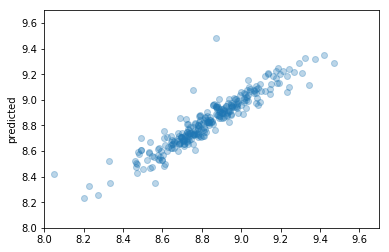

In [39]:
def predict_model(data):
    X = data.loc[:, data.columns != 'SalePrice']
    y = data.loc[:, 'SalePrice']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                        random_state=42)
    
    # Create linear regression object
    regr = linear_model.LinearRegression()
    regr.fit(X_train, y_train)
    return y_test, regr.predict(X_test)

y_test, y_preds = predict_model(new_dataset)
plt.scatter(y_test, y_preds, alpha=0.3)
plt.ylabel('predicted')
plt.xlim(8, 9.7)
plt.ylim(8, 9.7)
plt.show();

## Pitfalls

It seems that some of our FE steps have been discarded cause we got terrible R2 scores (exremely negative values). That means two things: our model used an split that teached nothing valuable for making good predictions; and we only scored once.

To illustrate the problem, let's see what happens when we evaluate our model using the current `score_model` function a number of times, changing the seed that generates the random split for training and test at every step.

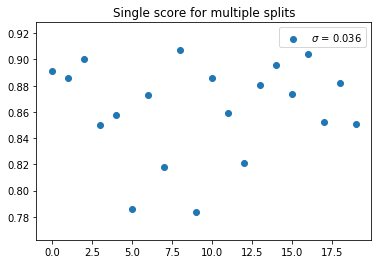

In [78]:
num_times = 20
scores1 = [score_model(dataset, seed=i) for i in range(num_times)]
plt.scatter(range(len(scores1)), scores1, 
            label='$\sigma$ = {:.3f}'.format(np.std(scores1)))
plt.legend(loc='best')
plt.title('Single score for multiple splits')
plt.show();

We need to rework our score_model to produce a range of metrics, in order to see if _on average_ we're getting better results or not. In the plot below you can see how our standard deviation is much lower with only 20 splits. If you increase the number of splits you can rapidly stabilize the expected R2 with CV, and get a much realistic measure of how your model will behave in the hold out dataset.

In [75]:
def score_model2(data, seed=666, splits=10):
    X = data.loc[:, data.columns != 'SalePrice']
    y = data.loc[:, 'SalePrice']
    X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                        test_size=0.20, 
                                                        random_state=seed)
    regr = linear_model.LinearRegression()
    scores = cross_val_score(regr, 
                             X_train, y_train, 
                             scoring='r2', cv=splits)
    return scores

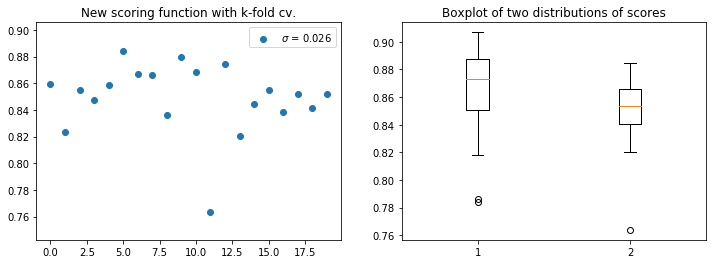

In [92]:
num_times = 20
scores2 = [np.mean(score_model2(dataset, seed=i)) for i in range(num_times)]

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.scatter(range(len(scores2)), scores2, 
            label='$\sigma$ = {:.3f}'.format(np.std(scores2)))
plt.legend(loc='best')
plt.title('New scoring function with k-fold cv.')

plt.subplot(1,2,2)
plt.boxplot([scores1, scores2])
plt.title('Boxplot of two distributions of scores')
plt.show();